# Toy Example

## Settings

\begin{align}
    S_{0}&\sim Bernoulli(0.5)\\
    M_{t}&\sim Bernoulli(expit(1.0-1.5S_{t}+2.5A_{t}))\\
    R_{t}&\sim Bernoulli(expit(1.0+2S_{t}-1A_{t}-2.5M_{t}))\\
    S_{t+1}&\sim Bernoulli(expit(.5+3.0S_{t}-2.5A_{t}-.5M_{t}))\\
    \pi_{b}&\sim Bernoulli(expit(1.0-2.0S{t}))\\
    \pi_{e}&\sim Bernoulli(expit(1.5+1.0S{t}))\\
    a_0&=0
\end{align}

In [150]:
import pickle
import numpy as np
import pandas as pd

### MC true $P_{\pi_e}(S_t)$

<AxesSubplot:>

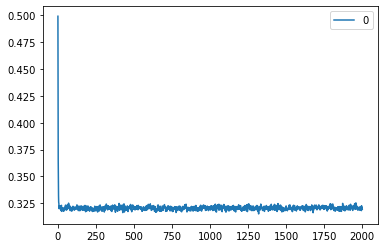

In [161]:
with open("true_eta.txt", 'rb') as p:
    x = pickle.load(p)
S = [rec[3] for rec in x[500][2000]]
pd.DataFrame(np.mean(np.vstack(S),0)).plot()

In [162]:
np.mean(np.vstack(S))

0.3207236581709146

<AxesSubplot:>

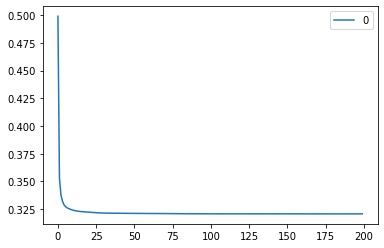

In [163]:
burn_in = 500
S = [rec[3] for rec in x[500][2000]]
mean = []
for n in range(1,2000,10):
    mean.append(np.mean(np.mean(np.vstack(S),0)[:n]))
pd.DataFrame(mean).plot()

In [164]:
mean[-1]

0.32072503264691105

### MC true $P_{a_{0}}(S_t)$


<AxesSubplot:>

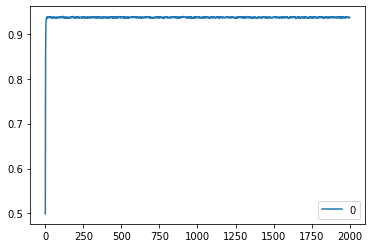

In [165]:
with open("true_eta_a0.txt", 'rb') as p:
    x = pickle.load(p)
S = [rec[3] for rec in x[500][2000]]
pd.DataFrame(np.mean(np.vstack(S),0)).plot()

In [166]:
np.mean(np.vstack(S))

0.9361090004997501

<AxesSubplot:>

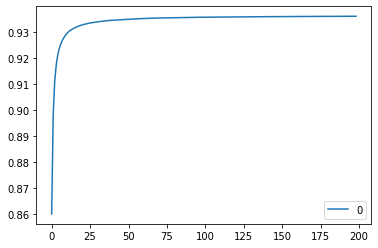

In [167]:
burn_in = 500
S = [rec[3] for rec in x[500][2000]]
mean = []
for n in range(10,2000,10):
    mean.append(np.mean(np.mean(np.vstack(S),0)[:n]))
pd.DataFrame(mean).plot()

In [168]:
mean[-1]

0.936107517587939

### MC true $P_{b}(S_t)$

<AxesSubplot:>

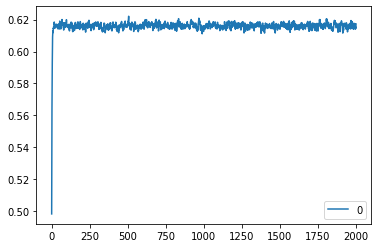

In [169]:
with open("true_pb_S.txt", 'rb') as p:
    x = pickle.load(p)
S = [rec[2] for rec in x[500][2000]]
pd.DataFrame(np.mean(np.vstack(S),0)).plot()

In [170]:
np.mean(np.vstack(S))

0.6158938480759618

<AxesSubplot:>

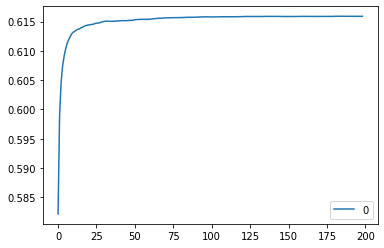

In [171]:
burn_in = 500
S = [rec[2] for rec in x[500][2000]]
mean = []
for n in range(10,2000,10):
    mean.append(np.mean(np.mean(np.vstack(S),0)[:n]))
pd.DataFrame(mean).plot()

In [172]:
mean[-1]

0.6158940552763817

In [181]:
0.9361090004997501/0.6158938480759618

1.5199193877713393

### Bellman:

\begin{align}
    E^{\pi}[R_{t}-\eta^{\pi}+V(S_{t+1})|S_{t}=s, A_{t}=a, M_{t}=m] = Q^{\pi}(S_{t},A_{t}, M_{t})
\end{align}

\begin{align}
    argmin_{Q}\sum_{i,t}^{\pi}[R_{t}-\eta^{\pi}+V(S_{t+1})-Q^{\pi}(S_{t},A_{t}, M_{T})]
\end{align}
,where $V(S_{t+1}) = E_{A,M}(Q^{\pi}(S_{t+1},A_{t+1}, M_{T+1}))$

Backdoor Adjustment:
\begin{align}
V(S_{t+1}) = \sum_{a,m} \pi(a|S_{t+1}) Q^{\pi}(m,a,S_{t+1})p(m|a,S_{t+1})
\end{align}


## True Q & True etas

In [3]:
def target_policy(state, action = None, matrix_based = False):
    if matrix_based:
        state1 = np.copy(state).flatten()
        pa = expit(1.5 + 1.0 * state1)
        if action is not None:
            action1 = np.copy(action).flatten()
            pa = pa * action1 + (1-pa) * (1-action1)
    else:
        pa = 1.5 + 1.0 * np.sum(state)
        pa = expit(pa)
        pa = np.random.binomial(n=1, p=pa, size=1)
    return pa
    
def toy_sa2mediator_model(state, action, matrix_based = False):
    if matrix_based:
        state1 = np.copy(state).flatten()
        action1 = np.copy(action).flatten()
        pm =  1.0 - 1.5 * state1 + 2.5 * action1
        pm = expit(pm)
    else:
        pm = 1.0 - 1.5 * state + 2.5 * action
        pm = expit(pm)
        pm = np.random.binomial(n=1, p=pm, size=1)
    return pm

def pmlearner(state, action, mediator):
    pm_one = toy_sa2mediator_model(state, action=action, matrix_based = True).flatten() 
    pm = mediator * pm_one + (1 - mediator) * (1 - pm_one)
    return pm

def control_policy(state = None, action=None, get_a = False, matrix_based=False):
    # fixed policy with fixed action 0
    if get_a:
        action_value = 0
        
    elif matrix_based:
        action1 = np.copy(action).flatten()
        action_value = 1 - action1 ###for a0 = 0 only
        
    else:
        if action is None:
            action_value = 0 
        else:
            if action == 0:
                action_value = 1
            else:
                action_value = 0
    return action_value

def toy_sam2reward_model(state, action, mediator, random = None, matrix_based = False):
        if matrix_based:
            #print("matrix")
            state1 = np.copy(state).flatten()
            action1 = np.copy(action).flatten()
            mediator1 = np.copy(mediator).flatten()
            rmean = 1.0 + 2 * state1 - 1 * action1 -  2.5 * mediator1
            #rmean = 1.0 * np.ones(shape = state1.shape[0])
            rmean = expit(rmean)
            if random is None:
                rmean *= 10
                reward = rmean
            else:
                print("wrong")
        else:
            rmean = 1.0 + 2 * state - 1 * action -  2.5 * mediator
            #rmean = 1.0
            rmean = expit(rmean)
            if random:
                reward = np.random.binomial(n=1, p=rmean, size=1) * 10
            else:
                rmean *= 10
                reward = rmean
        return reward

In [4]:
###true without estimating etas
from tqdm import tqdm
import pickle
import numpy as np
from scipy.special import expit
from multiprocessing import Pool
import Policy as policy
import Simulator as Simulator
import pandas as pd
from qLearner_MC import Qlearner as Qlearner_MC
def learnQ(Qlearner, simulator, traj,target_policy, control_policy, toy_sam2reward_model, true_etas=None):
    q1 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q1", true_etas=true_etas)
    b_hat1 = q1.fit()
    
    q2 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q2", true_etas=true_etas)
    b_hat2 = q2.fit()
    
    q3 = Qlearner(traj, simulator, target_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q3",true_etas=true_etas)
    b_hat3 = q3.fit()
    
    #traj1 = simulator.sample_target_policy_trajectory(num_trajectory=num_trajectory, num_time=num_time,
    #                                                 seed=seed, policy = "control", burn_in=False, return_trajectory=True)
    #traj1 = simulator.trajectory2iid(trajectory = traj1)
    
    q4 = Qlearner(traj, simulator, control_policy, pmlearner, toy_sam2reward_model, control_policy, Q_func = "Q4",true_etas=true_etas)
    b_hat4 = q4.fit()
    out = {'b_hat1':b_hat1, 'b_hat2':b_hat2, 'b_hat3':b_hat3,'b_hat4':b_hat4, 'q1':q1, 'q2':q2, 'q3':q3,'q4':q4}
    return out

simulator = Simulator.Simulator(dim_state=1, model_type='toy')
traj = simulator.sample_trajectory(num_trajectory=200, num_time=200,
                                                     seed=10, burn_in=False, return_trajectory=True)
traj = simulator.trajectory2iid(trajectory = traj)

out1 = learnQ(Qlearner_MC, simulator, traj, target_policy, control_policy, toy_sam2reward_model)
#out2 = learnQ(Qlearner2, target_policy, control_policy, toy_sam2reward_model)

out = []
for b in ['b_hat1','b_hat2','b_hat3','b_hat4']:
    out.append(out1[b])

In [5]:
out = pd.DataFrame(out,index = ['Q1','Q2','Q3','Q4'])
out

,0,1,2,3,4,5,6,7
Q1,4.546846,-5.680322,-6.306302,2.224551,1.124411,-10.211971,-3.535179,2.397011
Q2,5.362853,-4.549023,-6.593262,3.196803,1.897973,-10.427154,-1.085992,3.673697
Q3,8.448072,-5.012505,-1.219712,6.061331,8.267657,-5.444225,4.979667,4.896161
Q4,5.262259,-6.714231,-6.557886,2.447661,1.802611,-11.334928,-3.535179,7.963093


In [6]:
out.iloc[:,-1].to_numpy()

array([2.39701065, 3.67369661, 4.89616138, 7.96309271])

## True DE/ME/SE

In [9]:
    true_eta_pi = 2.39701065
    true_eta_pi_a0 = 3.67369661
    true_eta_pi_a0star = 4.89616138
    true_eta_a0 = 7.96309271
    DE = true_eta_pi - true_eta_pi_a0
    ME = true_eta_pi_a0 - true_eta_pi_a0star
    SE = true_eta_pi_a0star - true_eta_a0
    DE,ME,SE

(-1.27668596, -1.2224647699999998, -3.06693133)

## Robustness

In [1]:
import pickle
with open("robust_final.txt", 'rb') as p:
    Error = pickle.load(p)

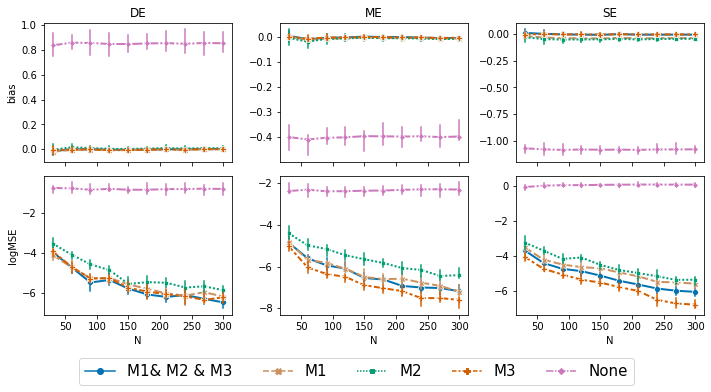

DE_error  ME_error  SE_error    DE_MSE    ME_MSE  \
N     correct_model                                                     
30.0  M1            -0.018500  0.000826 -0.018844 -4.090967 -4.825525   
      M1& M2 & M3   -0.014312  0.005019  0.010672 -3.940861 -4.855019   
      M2            -0.004015 -0.003352 -0.029259 -3.518698 -4.405961   
      M3            -0.008025  0.001833 -0.005151 -3.910716 -5.024162   
      None           0.835484 -0.399247 -1.070318 -0.744863 -2.380590   
60.0  M1            -0.005078 -0.011460 -0.032423 -4.701670 -5.671568   
      M1& M2 & M3    0.000171 -0.009343  0.002189 -4.705272 -5.604394   
      M2             0.017142 -0.019052 -0.047297 -4.072374 -4.982698   
      M3            -0.001638 -0.007108  0.000363 -4.677642 -6.042356   
      None           0.857027 -0.409228 -1.080510 -0.764061 -2.315745   
90.0  M1            -0.002717 -0.007031 -0.039569 -5.248701 -5.825690   
      M1& M2 & M3    0.000683 -0.003031 -0.002874 -5.462707 -5.943728   
      M2             0.010126 -0.007493 -0.051972 -4.559895 -5.163426   
      M3            -0.000690 -0.002236 -0.003541 -5.269317 -6.358942   
      None           0.854693 -0.402053 -1.085485 -0.836229 -2.394653   
120.0 M1            -0.006704 -0.005402 -0.039925 -5.238462 -6.111291   
      M1& M2 & M3   -0.002458 -0.002016 -0.005311 -5.336823 -6.100443   
      M2             0.004305 -0.005681 -0.050547 -4.844538 -5.461362   
      M3            -0.005971 -0.001905 -0.002147 -5.250931 -6.497577   
      None           0.846506 -0.400585 -1.081600 -0.787557 -2.388651   
150.0 M1            -0.006404 -0.001755 -0.041223 -5.559091 -6.499950   
      M1& M2 & M3   -0.003252  0.001566 -0.007226 -5.767653 -6.551941   
      M2             0.003158 -0.002675 -0.049734 -5.534923 -5.651239   
      M3            -0.005222  0.000604 -0.004741 -5.730843 -6.895977   
      None           0.846001 -0.395740 -1.084149 -0.834039 -2.363906   
180.0 M1            -0.004196 -0.004201 -0.035624 -5.775315 -6.606270   
      M1& M2 & M3   -0.002295 -0.000291 -0.000911 -6.062159 -6.622254   
      M2             0.006579 -0.004920 -0.045475 -5.446496 -5.831445   
      M3            -0.001588 -0.000848 -0.001205 -5.917961 -7.041306   
      None           0.850943 -0.396527 -1.082881 -0.832716 -2.357186   
210.0 M1            -0.001104 -0.003821 -0.040523 -6.013103 -6.585966   
      M1& M2 & M3    0.000949 -0.000562 -0.005851 -6.181919 -6.932208   
      M2             0.010041 -0.004867 -0.050486 -5.475151 -6.074212   
      M3            -0.000369 -0.001510 -0.003595 -6.050405 -7.180394   
      None           0.853267 -0.397435 -1.085226 -0.801668 -2.322630   
240.0 M1            -0.002246 -0.004325 -0.038839 -6.119328 -6.774924   
      M1& M2 & M3    0.000189 -0.002320 -0.005507 -6.088138 -7.006809   
      M2             0.006997 -0.005922 -0.046369 -5.713608 -6.164730   
      M3            -0.002747 -0.001760 -0.003272 -6.156514 -7.516088   
      None           0.848248 -0.396300 -1.081315 -0.799730 -2.300259   
270.0 M1             0.000810 -0.006621 -0.037742 -5.948984 -6.929240   
      M1& M2 & M3    0.002659 -0.004487 -0.005170 -6.279361 -7.032521   
      M2             0.010061 -0.008341 -0.045204 -5.653382 -6.454268   
      M3             0.001467 -0.003985 -0.003030 -6.332335 -7.513307   
      None           0.854365 -0.399404 -1.080822 -0.779874 -2.294794   
300.0 M1             0.001047 -0.006127 -0.037840 -6.165118 -7.204515   
      M1& M2 & M3    0.002041 -0.003863 -0.005770 -6.455319 -7.182628   
      M2             0.008810 -0.007172 -0.044558 -5.847082 -6.413424   
      M3             0.000462 -0.002914 -0.003707 -6.204242 -7.601883   
      None           0.852496 -0.397245 -1.080297 -0.794254 -2.311608   

                       SE_MSE  
N     correct_model            
30.0  M1            -3.505018  
      M1& M2 & M3   -3.679750  
      M2            -3.234141  
      M3            -4.041620  
      None          -0.087722  


In [2]:
from plot import plot, summary
import numpy as np
result = summary(Error, N_range = np.arange(1, 11) * 30, T_range = [50])
fig = plot(result,x='N')
result.groupby(['N','correct_model']).mean()[['DE_error','ME_error','SE_error','DE_MSE','ME_MSE','SE_MSE']]
